## *Maryam Mounad - Muhammad Humza Arain - Mahak Nadeem*

## Exercise 1 - Ensemble Learning (13 points)

### 1. Describe the key strengths of Decision Trees. Explain the disadvantages and a strategy to overcome their limitations. (2 points)

Some of the key strengths of Decisison Trees include:
1. Simple interpretation : Decision trees are easy to visualize and interpret (white box model )
2. Simple to apply few data preprocessing, handling of mixed numeric and categorical data
3. Implicit handling of missing values, e.g. via surrogate splits
4. Regression + classification
5. Implicit feature selection: Implicitly performs feature selection by choosing the best splits
6. Computationally efficient: O(#Attributs * n * log n)

Disadvantages: 
1. Instability: Small changes in the data can lead to different splits (high variance).
2. Overfitting: Prone to overfitting, especially when the tree is deep.
3. Approach is Greedy learning algorithm: fitting an optimal decision tree is NP hard 

Strategy to Overcome Limitations:
1. Use Ensemble Methods: Techniques like Random Forests or Gradient Boosting combine many decision trees to reduce variance and improve generalization.
2. Pruning: Post-pruning or pre-pruning can reduce overfitting by limiting the depth or complexity of the tree.

### 2. How does the Gini index help in the process of building a decision tree? Explain what the Gini index measures. What are the minimum and maximum possible values, and what do these values mean? (2 points)

The Gini index is a metric used to measure node impurity in classification trees. It quantifies how often a randomly chosen element would be incorrectly classified if it was randomly labeled according to the distribution of labels in the subset.

Minimum and Maximum Values:
Minimum = 0: Pure node (only one class present).
Maximum = (1 - 1/C): Occurs when classes are evenly distributed.
For binary classification (C = 2), max Gini = 0.5 when both classes are 50%.

During training, decision trees choose splits that minimize the Gini index, i.e., make child nodes more "pure." The split that results in the lowest Gini index (i.e., least impurity) is selected.

### 3a. Random forest, optimizing the number of estimators (2 points) 
### b. Lasso penalized logistic regression (1 point)
###  c. Elastic net penalized logistic regression (1 point) 

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score


df = pd.read_csv("C:/Users/ahmed/Desktop/Second_Semester/Biomedical_Data_Science/titanic_survival_data.csv")

# Feature and target separation
X = df.drop(columns=["PassengerId", "Label"])
y = df["Label"]

# Cross-validation strategies
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

scaler = StandardScaler()

predictions = {}

# --- a. RANDOM FOREST CLASSIFIER ---
rf_pipe = Pipeline([
    ("scaler", scaler),
    ("clf", RandomForestClassifier(random_state=0))
])

rf_param_grid = {
    "clf__n_estimators": [10, 50, 100, 150, 200]
}

rf_search = GridSearchCV(rf_pipe, rf_param_grid, cv=inner_cv, scoring="roc_auc", n_jobs=-1)
rf_probs = cross_val_predict(rf_search, X, y, cv=outer_cv, method="predict_proba", n_jobs=-1)[:, 1]
predictions["RandomForest"] = rf_probs

# --- b. LASSO LOGISTIC REGRESSION (L1) ---
lasso_pipe = Pipeline([
    ("scaler", scaler),
    ("clf", LogisticRegression(penalty='l1', solver='saga', random_state=0, max_iter=5000))
])

lasso_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100]
}

lasso_search = GridSearchCV(lasso_pipe, lasso_param_grid, cv=inner_cv, scoring="roc_auc", n_jobs=-1)
lasso_probs = cross_val_predict(lasso_search, X, y, cv=outer_cv, method="predict_proba", n_jobs=-1)[:, 1]
predictions["Lasso"] = lasso_probs

# --- c. ELASTIC NET LOGISTIC REGRESSION ---
elastic_pipe = Pipeline([
    ("scaler", scaler),
    ("clf", LogisticRegression(penalty='elasticnet', solver='saga', random_state=0, max_iter=5000))
])

elastic_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_search = GridSearchCV(elastic_pipe, elastic_param_grid, cv=inner_cv, scoring="roc_auc", n_jobs=-1)
elastic_probs = cross_val_predict(elastic_search, X, y, cv=outer_cv, method="predict_proba", n_jobs=-1)[:, 1]
predictions["ElasticNet"] = elastic_probs

print("Model ROC AUC Scores:")
for model, probs in predictions.items():
    auc = roc_auc_score(y, probs)
    print(f"{model}: {auc:.4f}")


Model ROC AUC Scores:
RandomForest: 0.8590
Lasso: 0.8442
ElasticNet: 0.8443


### 4.a.Describe how calibration curves can explain your model’s performance. (2 points)

Calibration curves, also known as reliability diagrams, help evaluate how well a model's predicted probabilities reflect actual outcomes. In other words, they show whether the confidence of a model’s predictions matches the true likelihood of the event occurring.

For example, if a model assigns a probability of 0.8 to a group of predictions, we expect around 80% of those predictions to be correct. A perfectly calibrated model would have a calibration curve that lies along the diagonal line (where predicted probability = actual frequency).

Calibration curves are important because a model can have a high accuracy or AUC but still produce poorly calibrated probabilities. By plotting these curves, we can visually assess whether a model is overconfident (predicting high probabilities when outcomes are less certain) or underconfident (predicting low probabilities when outcomes are more likely).

### b. Use the predicted probabilities of each model from question 1 to plot a calibration curve, then explain your results. (3 points)

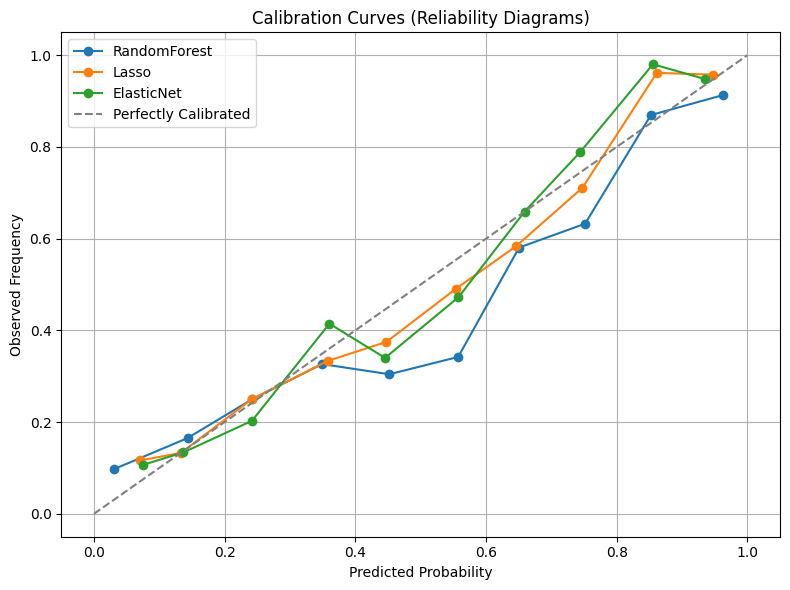

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Calibration curve plot
plt.figure(figsize=(8, 6))

# Plot calibration curve for each model
for model_name, probs in predictions.items():
    true_frac, pred_mean = calibration_curve(y, probs, n_bins=10, strategy='uniform')
    plt.plot(pred_mean, true_frac, marker='o', label=f'{model_name}')

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.title('Calibration Curves (Reliability Diagrams)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation:

The Random Forest model shows slight overconfidence (the curve dips below the diagonal), especially for higher probabilities.
The Lasso logistic regression is closer to the diagonal, indicating better calibration.
The Elastic Net performs similarly to Lasso, possibly with a small bias in low or mid probability ranges.

### Conclusion: 
Logistic models (Lasso, Elastic Net) are naturally better calibrated than tree-based models like Random Forests, which often require post-calibration.

# EXERCISE 2 - NN theoretical (12 points)

 **Suppose there is a Multi-Layer Perceptron (MLP) composed of one input layer with5 neurons, followed by one hidden layer with 20 artificial neurons, and one output layer with 2 artificial neurons. All artificial neurons use the ReLU activation function.**


**a). Deduce the shape of input matrix X, hidden layer’s weight vector Wh, bias vector bh and the shape of the network’s output matrix Y.**

 **1. Input Matrix** $X$  
Each sample has 5 features, and we have $N$ samples.  

**Shape:**  
$$X \in \mathbb{R}^{N \times 5}$$

**2. Hidden Layer Weights** $W_h$  
$W_h$ maps the 5 input features to 20 hidden neurons.  

For matrix multiplication $X \cdot W_h$, dimensions must align:

$$ (N \times 5) \cdot (5 \times 20) = N \times 20 $$

**Shape:**  
$$W_h \in \mathbb{R}^{5 \times 20}$$

 **3. Hidden Layer Bias** $b_h$  
One bias per hidden neuron = 20 total.  

Added **broadcast-wise** across all samples.  

**Shape:**  
$$b_h \in \mathbb{R}^{1 \times 20} \quad \text{or} \quad \mathbb{R}^{20}$$

 **4. Output Layer Weights** $W_o$  
Maps 20 hidden neurons to 2 output neurons.  

After activation, hidden output is $N \times 20$, so:

$$ (N \times 20) \cdot (20 \times 2) = N \times 2 $$

**Shape:**  
$$W_o \in \mathbb{R}^{20 \times 2}$$

 **5. Output Layer Bias** $b_o$  
One bias per output neuron = 2 total.  

**Shape:**  
$$b_o \in \mathbb{R}^{1 \times 2} \quad \text{or} \quad \mathbb{R}^{2}$$

 **6. Final Output Matrix** $Y$  
Network outputs **2 values** (e.g., for classification or regression) for each of $N$ samples.  

**Shape:**  
$$Y \in \mathbb{R}^{N \times 2}$$

**b. Write the equation that computes the network’s output matrix Y as a function of X, Wh , bh , Wo and bo. (2 points)**


**Step-by-Step Computation**

**1. Hidden Layer Linear Transformation**
$$ Z_h = X W_h + b_h \quad \text{(shape: } N \times 20 \text{)} $$

**2. Hidden Layer Activation (ReLU)**
$$ H = \text{ReLU}(Z_h) = \max(0, Z_h) $$

**3. Output Layer Linear Transformation**
$$ Y = H W_o + b_o \quad \text{(shape: } N \times 2 \text{)} $$

 **Final Equation**
$$ Y = (\max(0, X W_h + b_h)) W_o + b_o $$


2. Consider the 3 layer neural network with the initial weights as given in Figure 1.
Write a simple, self-contained python code to
a. Compute the activations h1, h2, and the output o1 using the sigmoid
activation function as well as the total Binary Cross Entropy loss for the
expected output. (3 points)

In [2]:
import numpy as np

# Sigmoid activation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Binary Cross-Entropy loss
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-10
    return - (y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

# Inputs
i1 = 0.5
i2 = 0.8

# Weights
w1 = 0.3   # i1 → h1
w2 = 0.33  # i2 → h1
w3 = 0.11  # i1 → h2
w4 = 0.9   # i2 → h2
w5 = 0.44  # h1 → o1
w6 = 0.55  # h2 → o1

# Biases
b1 = 0.8   # for h1
b2 = 0.1   # for h2
b3 = 0.9   # for o1

# Expected output
y_true = 1

# Compute hidden layer
z_h1 = i1 * w1 + i2 * w2 + b1
h1 = sigmoid(z_h1)

z_h2 = i1 * w3 + i2 * w4 + b2
h2 = sigmoid(z_h2)

# Compute output layer
z_o1 = h1 * w5 + h2 * w6 + b3
o1 = sigmoid(z_o1)

# Compute loss
loss = binary_cross_entropy(y_true, o1)

# Output
print(f"h1 = {h1:.4f}")
print(f"h2 = {h2:.4f}")
print(f"o1 = {o1:.4f}")
print(f"Binary Cross-Entropy Loss = {loss:.4f}")


h1 = 0.7710
h2 = 0.7058
o1 = 0.8358
Binary Cross-Entropy Loss = 0.1793


b. Compute the updates for the weights w1, …, w6 and bias terms b1, b2, b3
using one step of backpropagation. Assume a learning rate of 1 for the
sake of simplicity. (5 points)
Note: Remember that a bias term is equivalent to a weighted constant
input 1.
You should not use any other library than numpy in your code.



In [ ]:
import numpy as np

# Sigmoid and derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

# Inputs
i1, i2 = 0.5, 0.8
y = 1
lr = 1  # learning rate

# Initial weights and biases
w1, w2 = 0.3, 0.33
w3, w4 = 0.11, 0.9
w5, w6 = 0.44, 0.55
b1, b2, b3 = 0.8, 0.1, 0.9

#FORWARD PASS
z_h1 = i1 * w1 + i2 * w2 + b1
h1 = sigmoid(z_h1)

z_h2 = i1 * w3 + i2 * w4 + b2
h2 = sigmoid(z_h2)

z_o = h1 * w5 + h2 * w6 + b3
o1 = sigmoid(z_o)

#BACKWARD PASS
# Output layer gradients
dL_do = o1 - y
do_dzo = sigmoid_deriv(z_o)

# Gradients for output weights and bias
dL_dw5 = dL_do * h1
dL_dw6 = dL_do * h2
dL_db3 = dL_do

# Gradients for hidden layer outputs
dL_dh1 = dL_do * w5
dL_dh2 = dL_do * w6

# Hidden layer derivatives
dh1_dzh1 = sigmoid_deriv(z_h1)
dh2_dzh2 = sigmoid_deriv(z_h2)

# Gradients for hidden weights and biases
dL_dw1 = dL_dh1 * dh1_dzh1 * i1
dL_dw2 = dL_dh1 * dh1_dzh1 * i2
dL_db1 = dL_dh1 * dh1_dzh1

dL_dw3 = dL_dh2 * dh2_dzh2 * i1
dL_dw4 = dL_dh2 * dh2_dzh2 * i2
dL_db2 = dL_dh2 * dh2_dzh2

#PARAMETER UPDATE
# Output layer
w5 -= lr * dL_dw5
w6 -= lr * dL_dw6
b3 -= lr * dL_db3

# Hidden layer
w1 -= lr * dL_dw1
w2 -= lr * dL_dw2
b1 -= lr * dL_db1

w3 -= lr * dL_dw3
w4 -= lr * dL_dw4
b2 -= lr * dL_db2


print("Updated weights and biases:")
print(f"w1 = {w1:.4f}, w2 = {w2:.4f}, b1 = {b1:.4f}")
print(f"w3 = {w3:.4f}, w4 = {w4:.4f}, b2 = {b2:.4f}")
print(f"w5 = {w5:.4f}, w6 = {w6:.4f}, b3 = {b3:.4f}")


Updated weights and biases:
w1 = 0.3064, w2 = 0.3402, b1 = 0.8128
w3 = 0.1194, w4 = 0.9150, b2 = 0.1188
w5 = 0.5666, w6 = 0.6659, b3 = 1.0642


**3) What are the principal and unavoidable limitations of the backpropagation (BP) algorithm?**

Backpropagation suffers from vanishing/exploding gradients, sensitivity to initialization and hyperparameters, and overfitting, especially in deep or recurrent networks. It lacks biological plausibility and can get stuck in local minima or saddle points. While practical fixes exist (e.g., ReLU, batch norm), these limitations are fundamentally unavoidable.








